# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator Understanding

The 2-pager description of universal statistical simulator can be found here.

## Part II - General Algorithm for Quantum Galton Box

In [62]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [183]:
get_device = lambda n: qml.device("default.qubit", wires=2*n+2, shots=2048)

In [297]:
def calculate_wire_tuples(n, level) -> list:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i+1) for i in range(middle - level, middle + level)]


def create_qgb_circuit(n, coin):
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    dev = get_device(n)
        
    def qpegs(wire_tuples):
        for i, wires in enumerate(wire_tuples):
            qml.CSWAP(wires=[0, wires[0], wires[1]])
            if i < len(wire_tuples) - 1:
                qml.CNOT(wires=[wires[1], 0])
    

    @qml.qnode(dev)
    def qgb_circuit():
        qml.X(wires=n+1)
        for level in range(1, n+1):
            coin(level)
            qpegs(wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qml.measure(wires=0, reset=True)
        return qml.sample(wires=range(1, 2*n+2, 2))
    
    return qgb_circuit


In [298]:
def run_circuit(n, coin_function, reverse=False):
    my_circuit = create_qgb_circuit(n, coin=coin_function)
    samples = my_circuit()
    bitstrings = ["".join(str(bit) for bit in sample) for sample in samples]
    freqs = Counter(bitstrings)
    freqs = dict(sorted(freqs.items(), reverse=reverse))
    return freqs

In [327]:
def plot_freqs(freqs, title, reference_values=None):
    """Plots the frequencies of bitstrings as a histogram, with optional reference line."""
    plt.bar(freqs.keys(), freqs.values(), label="Quantum Galton Box")
    if reference_values is not None:
        plt.plot(list(freqs.keys()), reference_values, color="red", marker="o", linestyle="-", label="Reference")
    plt.xlabel("Bitstring")
    plt.ylabel("Frequency")
    plt.title(title)
    if reference_values is not None:
        plt.legend()
    plt.show()

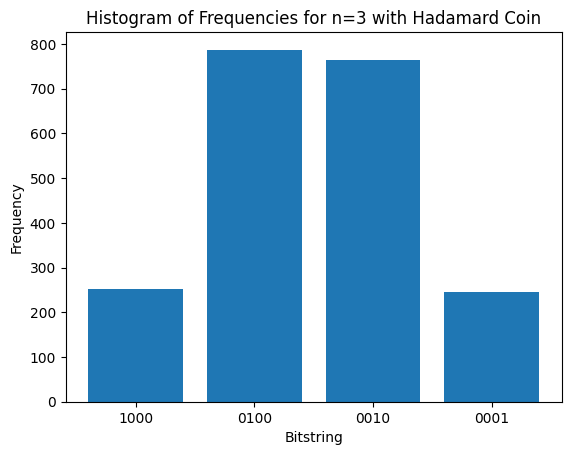

In [328]:
n = 3
coin_function = lambda level: qml.Hadamard(wires=0)
freqs = run_circuit(n, coin_function, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Hadamard Coin")

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

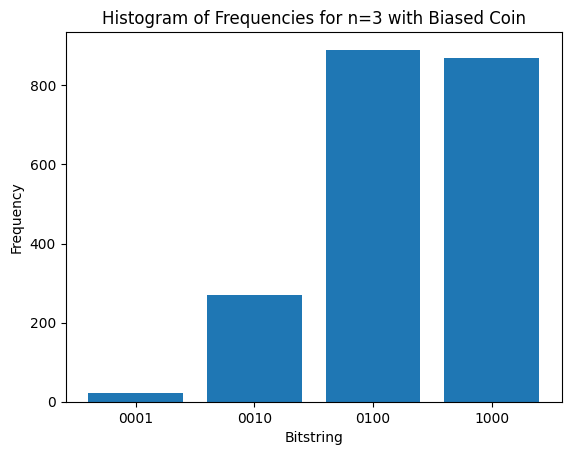

In [329]:
n = 3
coin_function = lambda level: qml.RY(2*np.pi/3, 0)
freqs = run_circuit(n, coin_function)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Biased Coin")

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [330]:
def exponential_coin(level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * np.acos(np.sqrt(1 / np.e)) 
    if level == 1:
        qml.RY(theta, wires=0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qml.CNOT(wires=[i, 0])
        qml.CRY(theta, wires=[middle + level - 1, 0])

[1283  475  181   69   24    9]


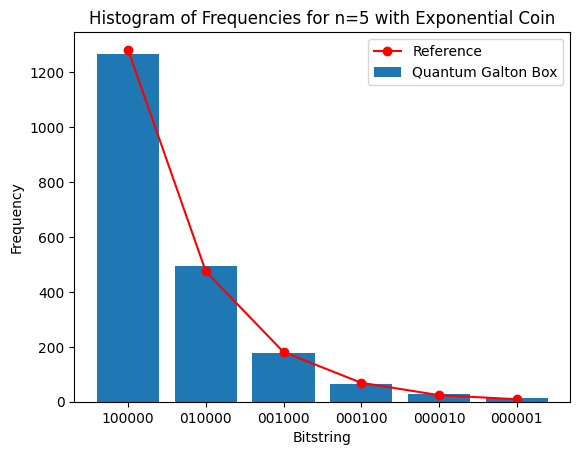

In [336]:
n = 5
exp_samples = np.random.exponential(scale=1, size=2048)
reference_freqs = np.arange(0, n+2)

reference_freqs = np.histogram(exp_samples, bins=reference_freqs, density=False)[0]
print(reference_freqs)
freqs = run_circuit(n, exponential_coin, reverse=True)
plot_freqs(freqs, title=f"Histogram of Frequencies for n={n} with Exponential Coin", reference_values=reference_freqs)

(<Figure size 3700x1100 with 1 Axes>, <Axes: >)

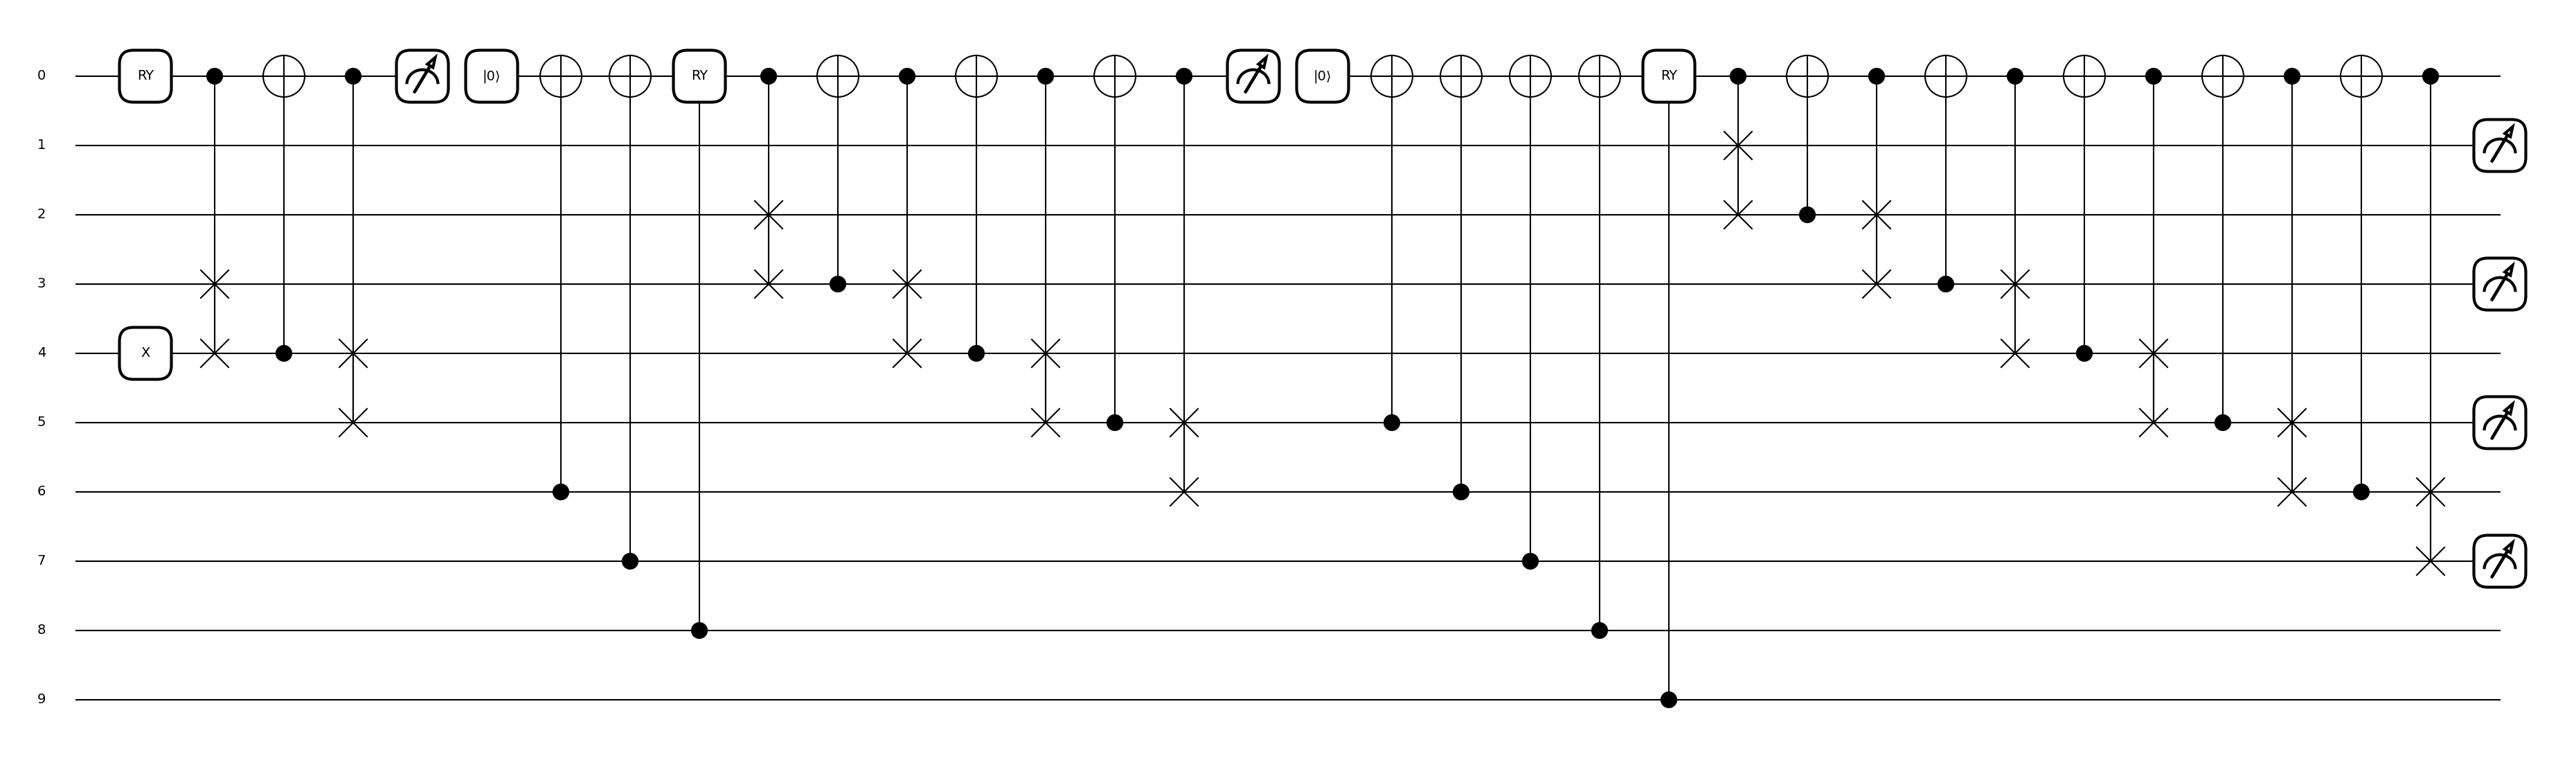

In [304]:
circuit = create_qgb_circuit(3, coin=exponential_coin)
qml.draw_mpl(circuit, show_all_wires=True)()

### Hadamard Quantum Walk